In [3]:
from __future__ import annotations
import pickle
import numpy as np
from edpyt.dmft import DMFT, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from scipy.interpolate import interp1d
from edpyt.nano_dmft import Gfloc

import numpy as np
import matplotlib.pyplot as plt
import os
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)


In [5]:
nbaths = 4
# U = 4
tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3
z_ret = energies + 1.0j * eta
beta = 1000
mu = 0.0
adjust_mu = True
use_double_counting = True

data_folder = "output/lowdin"

occupancy_goal = np.load(f"{data_folder}/beta_{beta}/occupancies.npy")
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

In [ ]:
len_active = occupancy_goal.size
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.loadtxt(f"{data_folder}/U_matrix.txt")
# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)
gfloc = Gfloc(
    H_active - double_counting,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)

nimp = gfloc.idx_neq.size
gfimp = [Gfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

Sigma = lambda z: np.zeros((nimp, z.size), complex)

gfloc0 = Gfloc(
    H_active, S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta
)
gfloc0.update(mu=mu)
gfloc0.set_local(Sigma)

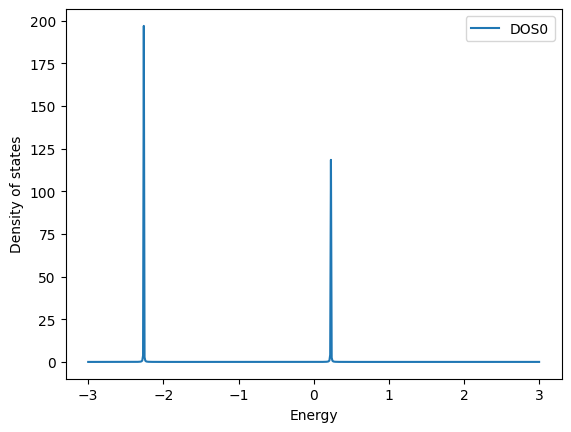

In [8]:
dos0 = -1 / np.pi * gfloc0(z_ret).sum(axis=0).imag
# dos = -1 / np.pi * gfloc(z_ret).sum(axis=0).imag
plt.plot(z_ret.real, dos0, label="DOS0")
# plt.plot(z_ret.real, dos, label="DOS")
plt.xlabel("Energy")
plt.ylabel("Density of states")
plt.legend()